In [1]:
import numpy as np
import pandas as pd

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "12"

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

2024-06-18 17:44:05.483527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from utils import (
    splitter,
    create_plot,
    forecast_accuracy
)

In [5]:
# Check everything with Tensorflow works 
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
# tf.keras.utils.set_random_seed(5)
# tf.config.experimental.enable_op_determinism()

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0

Python 3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [6]:
# tf.keras.utils.set_random_seed(10)
# tf.config.experimental.enable_op_determinism()

In [7]:
metrics_ = pd.DataFrame()

### Loading the Dataset

In [8]:
ts_prices_eth = pd.read_csv("Data/Time_Series/prices/ethereum_19_22.csv",index_col='date',parse_dates=['date'])

In [9]:
# crypto = 'crypto_bitcoin'
crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

### Vader

In [10]:
model ='VADER'
df= pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [11]:
ts_prices_eth= ts_prices_eth.join(df)

In [12]:
# Remove Neutral Time Series
for c in ts_prices_eth.columns:
    if 'prop' in c.lower() or 'neutral' in c.lower() or 'mean' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_eth.drop(c,axis=1,inplace=True)

Dropping column neutral_count
Dropping column mean_vader_score


In [13]:
ts_prices_eth.head(4) #.shape

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length
date,,,,,,,,
2019-01-01,131.46,11,1,37,2068,838,750,6.196416
2019-01-02,138.14,19,3,81,3005,1137,1502,6.615711
2019-01-03,152.86,24,4,87,3850,1446,1192,6.966658
2019-01-04,146.73,13,2,63,1805,675,1293,6.364462


In [14]:
df = ts_prices_eth

### Adding Features

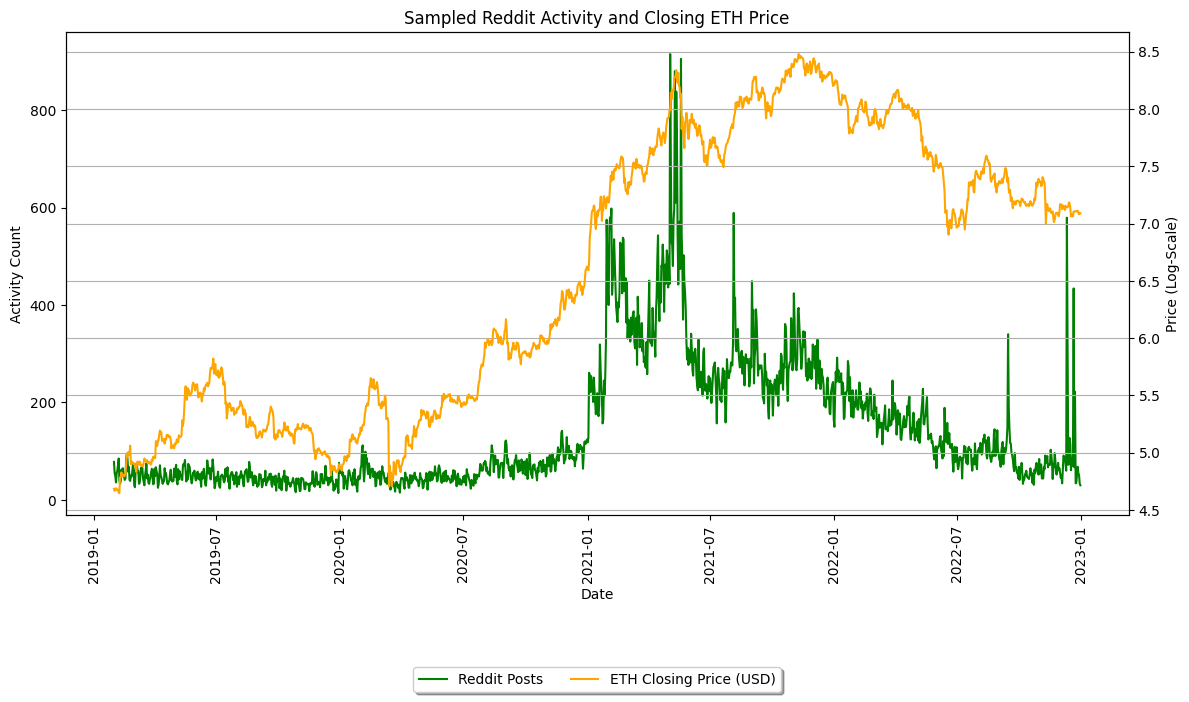

In [63]:

fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'red'
ax1.set_xlabel('date')
ax1.set_ylabel('Activity Count', color='black')
ax1.plot(df.index, df['total_posts'], color='green', label=f'Reddit Posts')
# ax1.plot(df.index, df[['total_comments']], color='yellow', label=f'Reddit Posts')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('Price (Log-Scale)', color='black')  # we already handled the x-label with ax1
ax2.plot(df.index, np.log(df.price), color='orange', label=f'ETH Closing Price (USD)')
ax2.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3)
ax1.set_xlabel('Date', color='black') 

plt.title(f'Sampled Reddit Activity and Closing ETH Price')
# plt.xticks(ts_pos_sub.index)
plt.grid()
plt.show()

In [16]:
df.total_posts.max(),df.price.max()

(915, 4815.0)

In [17]:
df.head()

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length
date,,,,,,,,
2019-01-01,131.46,11,1,37,2068,838,750,6.196416
2019-01-02,138.14,19,3,81,3005,1137,1502,6.615711
2019-01-03,152.86,24,4,87,3850,1446,1192,6.966658
2019-01-04,146.73,13,2,63,1805,675,1293,6.364462
2019-01-05,153.06,17,2,71,2634,995,1053,6.545905


In [18]:
n_lags = 14
for lag in range(1, n_lags + 1):
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

In [19]:
window_sizes = [7, 14, 30]  # Window sizes for moving averages
for window_size in window_sizes:
    df[f'price_ma_{window_size}'] = df['price_lag_1'].rolling(window=window_size).mean()

In [20]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [21]:
df.isna().sum()

price                   0
positive_count          0
negative_count          0
total_posts             0
total_words             0
total_stopwords         0
total_comments          0
average_word_length     0
price_lag_1             1
price_lag_2             2
price_lag_3             3
price_lag_4             4
price_lag_5             5
price_lag_6             6
price_lag_7             7
price_lag_8             8
price_lag_9             9
price_lag_10           10
price_lag_11           11
price_lag_12           12
price_lag_13           13
price_lag_14           14
price_ma_7              7
price_ma_14            14
price_ma_30            30
day_of_week             0
month                   0
year                    0
dtype: int64

In [22]:
df = df[30:]

In [23]:
test_split=round(len(df)*0.40)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
val_split=round(len(df_for_testing)*0.50)
df_for_validation=df_for_testing[:-val_split]
df_for_testing=df[-val_split:]
print(f"Training Set: {df_for_training.shape}")
print(f"Validation Set: {df_for_validation.shape}")
print(f"Testing Set: {df_for_testing.shape}")

Training Set: (859, 28)
Validation Set: (286, 28)
Testing Set: (286, 28)


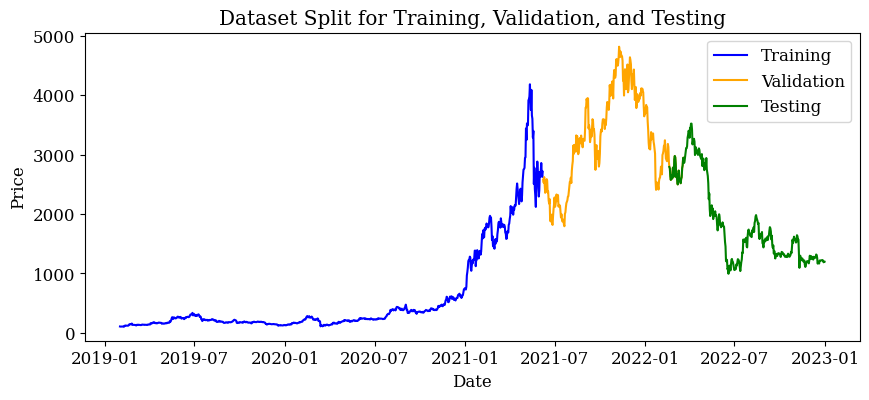

In [69]:
plt.figure(figsize=(10, 4))

plt.plot(df_for_training.index, df_for_training['price'], label='Training', color='blue')
plt.plot(df_for_validation.index, df_for_validation['price'], label='Validation', color='orange')
plt.plot(df_for_testing.index, df_for_testing['price'], label='Testing', color='green')

# Add title and labels
plt.title('Dataset Split for Training, Validation, and Testing')
plt.xlabel('Date')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show plot
plt.show()

In [26]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled.shape, df_for_validation_scaled.shape

((859, 28), (286, 28))

In [27]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
valX,valY=createXY(df_for_validation_scaled,30)

In [28]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(30,return_sequences=True,input_shape=(30,27)))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))
parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/var/folders/2l/h6ht9_t96fn33pfzbxcdp_dm0000gn/T/ipykernel_8477/1645025208.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))


In [29]:
grid_search = grid_search.fit(trainX,trainY)

2024-06-18 17:44:10.665895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 17:44:10.665954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-18 17:44:11.328204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:11.329738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

Epoch 1/8


2024-06-18 17:44:11.943429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:11.945352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:11.946568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0255

2024-06-18 17:44:17.391993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:17.393669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:17.394745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 7s 90ms/step - loss: 0.0255 - val_loss: 0.0678
Epoch 2/8
26/26 [==============================] - 1s 39ms/step - loss: 0.0055 - val_loss: 0.0624
Epoch 3/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0045 - val_loss: 0.0748
Epoch 4/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0605
Epoch 5/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0039 - val_loss: 0.0433
Epoch 6/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0036 - val_loss: 0.0528
Epoch 7/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0030 - val_loss: 0.0641
Epoch 8/8
26/26 [==============================] - 1s 40ms/step - loss: 0.0032 - val_loss: 0.0550


2024-06-18 17:44:25.507939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:25.509986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:25.511337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 19ms/step - loss: 2.3234e-04


2024-06-18 17:44:27.063350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:27.065449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:27.066758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:44:27.543041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:27.544797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:27.546098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0013

2024-06-18 17:44:34.230348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:34.232627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:34.234236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 8s 126ms/step - loss: 0.0013 - val_loss: 0.7370
Epoch 2/8
26/26 [==============================] - 2s 69ms/step - loss: 2.6128e-04 - val_loss: 0.4818
Epoch 3/8
26/26 [==============================] - 2s 72ms/step - loss: 1.5052e-04 - val_loss: 0.4468
Epoch 4/8
26/26 [==============================] - 2s 66ms/step - loss: 1.2232e-04 - val_loss: 0.4309
Epoch 5/8
26/26 [==============================] - 2s 86ms/step - loss: 1.2341e-04 - val_loss: 0.4531
Epoch 6/8
26/26 [==============================] - 2s 63ms/step - loss: 8.1249e-05 - val_loss: 0.4339
Epoch 7/8
26/26 [==============================] - 2s 60ms/step - loss: 7.3829e-05 - val_loss: 0.4426
Epoch 8/8
26/26 [==============================] - 2s 60ms/step - loss: 8.1197e-05 - val_loss: 0.4282


2024-06-18 17:44:48.739106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:48.741379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:48.744078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 18ms/step - loss: 0.0519


2024-06-18 17:44:50.458219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:50.460294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:50.462521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:44:50.743357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:50.745499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:50.747072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0313

2024-06-18 17:44:57.516150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:44:57.517849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:44:57.518932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 8s 106ms/step - loss: 0.0313 - val_loss: 0.0247
Epoch 2/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0059 - val_loss: 0.0441
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0046 - val_loss: 0.0642
Epoch 4/10
26/26 [==============================] - 1s 40ms/step - loss: 0.0037 - val_loss: 0.0473
Epoch 5/10
26/26 [==============================] - 1s 58ms/step - loss: 0.0041 - val_loss: 0.0421
Epoch 6/10
26/26 [==============================] - 2s 59ms/step - loss: 0.0034 - val_loss: 0.0435
Epoch 7/10
26/26 [==============================] - 2s 78ms/step - loss: 0.0034 - val_loss: 0.0308
Epoch 8/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0032 - val_loss: 0.0671
Epoch 9/10
26/26 [==============================] - 2s 65ms/step - loss: 0.0031 - val_loss: 0.0573
Epoch 10/10
26/26 [==============================] - 1s 39ms/step - loss: 0.0027 - val_loss: 0.0480


2024-06-18 17:45:10.545429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:10.547625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:10.548963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 15ms/step - loss: 2.6408e-04


2024-06-18 17:45:12.535810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:12.537183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:12.538175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:45:13.003133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:13.004859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:13.006195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0012

2024-06-18 17:45:18.856446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:18.858252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:18.859426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 7s 94ms/step - loss: 0.0012 - val_loss: 0.6412
Epoch 2/10
26/26 [==============================] - 1s 50ms/step - loss: 2.8563e-04 - val_loss: 0.4620
Epoch 3/10
26/26 [==============================] - 1s 40ms/step - loss: 1.7476e-04 - val_loss: 0.4231
Epoch 4/10
26/26 [==============================] - 2s 63ms/step - loss: 1.2010e-04 - val_loss: 0.3513
Epoch 5/10
26/26 [==============================] - 1s 39ms/step - loss: 8.8612e-05 - val_loss: 0.3293
Epoch 6/10
26/26 [==============================] - 1s 39ms/step - loss: 8.8599e-05 - val_loss: 0.3246
Epoch 7/10
26/26 [==============================] - 1s 39ms/step - loss: 7.6297e-05 - val_loss: 0.3153
Epoch 8/10
26/26 [==============================] - 1s 41ms/step - loss: 6.4805e-05 - val_loss: 0.3014
Epoch 9/10
26/26 [==============================] - 1s 47ms/step - loss: 5.9353e-05 - val_loss: 0.3122
Epoch 10/10
26/26 [==============================] - 1s 39ms/step - loss: 6.8982e-05 - v

2024-06-18 17:45:30.287990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:30.289843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:30.290933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 16ms/step - loss: 0.0331


2024-06-18 17:45:31.699380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:31.700904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:31.702139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:45:32.334795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:32.337319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:32.339185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0188

2024-06-18 17:45:39.639043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:39.640731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:39.642117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 9s 162ms/step - loss: 0.0188 - val_loss: 0.1243
Epoch 2/8
21/21 [==============================] - 1s 60ms/step - loss: 0.0067 - val_loss: 0.0917
Epoch 3/8
21/21 [==============================] - 2s 74ms/step - loss: 0.0042 - val_loss: 0.0800
Epoch 4/8
21/21 [==============================] - 1s 43ms/step - loss: 0.0046 - val_loss: 0.0650
Epoch 5/8
21/21 [==============================] - 1s 58ms/step - loss: 0.0039 - val_loss: 0.0750
Epoch 6/8
21/21 [==============================] - 1s 64ms/step - loss: 0.0039 - val_loss: 0.0570
Epoch 7/8
21/21 [==============================] - 1s 72ms/step - loss: 0.0034 - val_loss: 0.0321
Epoch 8/8
21/21 [==============================] - 1s 23ms/step - loss: 4.6879e-04


2024-06-18 17:45:50.836624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:50.838558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:50.839929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:45:51.072110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:51.074163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:51.075432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 7.4025e-04

2024-06-18 17:45:57.819176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:45:57.820913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:45:57.822814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 8s 130ms/step - loss: 7.4025e-04 - val_loss: 0.4622
Epoch 2/8
21/21 [==============================] - 1s 41ms/step - loss: 2.2026e-04 - val_loss: 0.3306
Epoch 3/8
21/21 [==============================] - 1s 44ms/step - loss: 1.2571e-04 - val_loss: 0.3847
Epoch 4/8
21/21 [==============================] - 1s 55ms/step - loss: 1.0937e-04 - val_loss: 0.3759
Epoch 5/8
21/21 [==============================] - 1s 42ms/step - loss: 7.5121e-05 - val_loss: 0.3510
Epoch 6/8
21/21 [==============================] - 1s 42ms/step - loss: 6.5992e-05 - val_loss: 0.3639
Epoch 7/8
21/21 [==============================] - 1s 41ms/step - loss: 6.0854e-05 - val_loss: 0.3930
Epoch 8/8
21/21 [==============================] - 0s 16ms/step - loss: 0.0440


2024-06-18 17:46:06.131766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:06.133417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:06.134523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:46:06.593108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:06.594856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:06.596099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0297

2024-06-18 17:46:11.592283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:11.593664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:11.594754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 112ms/step - loss: 0.0297 - val_loss: 0.0477
Epoch 2/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0078 - val_loss: 0.0537
Epoch 3/10
21/21 [==============================] - 1s 49ms/step - loss: 0.0056 - val_loss: 0.0774
Epoch 4/10
21/21 [==============================] - 1s 44ms/step - loss: 0.0051 - val_loss: 0.0654
Epoch 5/10
21/21 [==============================] - 1s 46ms/step - loss: 0.0043 - val_loss: 0.0448
Epoch 6/10
21/21 [==============================] - 1s 42ms/step - loss: 0.0034 - val_loss: 0.0519
Epoch 7/10
21/21 [==============================] - 1s 43ms/step - loss: 0.0032 - val_loss: 0.0799
Epoch 8/10
21/21 [==============================] - 1s 48ms/step - loss: 0.0037 - val_loss: 0.0540
Epoch 9/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0033 - val_loss: 0.0661
Epoch 10/10
21/21 [==============================] - 0s 16ms/step - loss: 2.1584e-04


2024-06-18 17:46:21.692086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:21.693663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:21.694764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:46:22.871725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:22.874316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:22.875637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0060

2024-06-18 17:46:29.064993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:29.066612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:29.067928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 8s 135ms/step - loss: 0.0060 - val_loss: 0.7364
Epoch 2/10
21/21 [==============================] - 1s 44ms/step - loss: 8.7437e-04 - val_loss: 0.6805
Epoch 3/10
21/21 [==============================] - 1s 51ms/step - loss: 4.6043e-04 - val_loss: 0.5987
Epoch 4/10
21/21 [==============================] - 1s 47ms/step - loss: 3.1278e-04 - val_loss: 0.5415
Epoch 5/10
21/21 [==============================] - 1s 58ms/step - loss: 2.3893e-04 - val_loss: 0.4863
Epoch 6/10
21/21 [==============================] - 1s 69ms/step - loss: 1.8784e-04 - val_loss: 0.4498
Epoch 7/10
21/21 [==============================] - 1s 49ms/step - loss: 1.7743e-04 - val_loss: 0.4074
Epoch 8/10
21/21 [==============================] - 1s 56ms/step - loss: 1.3161e-04 - val_loss: 0.3915
Epoch 9/10
21/21 [==============================] - 1s 62ms/step - loss: 1.2141e-04 - val_loss: 0.3661
Epoch 10/10
21/21 [==============================] - 0s 21ms/step - loss: 0.0516


2024-06-18 17:46:41.415586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:41.417234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:41.418421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:46:41.875226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:41.877150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:41.878384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

52/52 [==============================] - ETA: 0s - loss: 0.0106

2024-06-18 17:46:48.387076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:46:48.388774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:46:48.389963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

52/52 [==============================] - 8s 65ms/step - loss: 0.0106 - val_loss: 0.0576
Epoch 2/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0027 - val_loss: 0.0688
Epoch 3/10
52/52 [==============================] - 2s 36ms/step - loss: 0.0024 - val_loss: 0.0315
Epoch 4/10
52/52 [==============================] - 2s 35ms/step - loss: 0.0021 - val_loss: 0.0542
Epoch 5/10
52/52 [==============================] - 3s 54ms/step - loss: 0.0018 - val_loss: 0.0345
Epoch 6/10
52/52 [==============================] - 2s 44ms/step - loss: 0.0019 - val_loss: 0.0485
Epoch 7/10
52/52 [==============================] - 3s 48ms/step - loss: 0.0014 - val_loss: 0.0362
Epoch 8/10
52/52 [==============================] - 2s 39ms/step - loss: 0.0011 - val_loss: 0.0386
Epoch 9/10
52/52 [==============================] - 2s 38ms/step - loss: 0.0013 - val_loss: 0.0449
Epoch 10/10
52/52 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0380


In [30]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [31]:
my_model_all=grid_search.best_estimator_.model

In [32]:
my_model_all.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 30)            6960      
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 14,311
Trainable params: 14,311
Non-trainable params: 0
_________________________________________________________________


In [33]:
df.shape

(1431, 28)

In [34]:
df_for_validation[-30:].shape, df_for_validation[-30:].index[0]

((30, 28), Timestamp('2022-02-19 00:00:00'))

In [35]:
df_for_testing = pd.concat([df_for_validation[-30:],df_for_testing])

In [36]:
df_for_testing.shape

(316, 28)

In [37]:
df_for_testing_scaled = scaler.transform(df_for_testing)
testX,testY=createXY(df_for_testing_scaled,30)
pred = my_model_all.predict(testX)
prediction_copies_array = np.repeat(pred,28, axis=-1)
predicted_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(pred),28)))[:,0]

2024-06-18 17:47:09.875664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:47:09.877906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:47:09.879336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 2s 29ms/step


In [38]:
predicted_prices.shape

(286,)

In [39]:
df_for_testing[30:].shape

(286, 28)

In [40]:
n_df= pd.DataFrame()
n_df.index = df_for_testing.index[30:]
n_df['price'] = predicted_prices

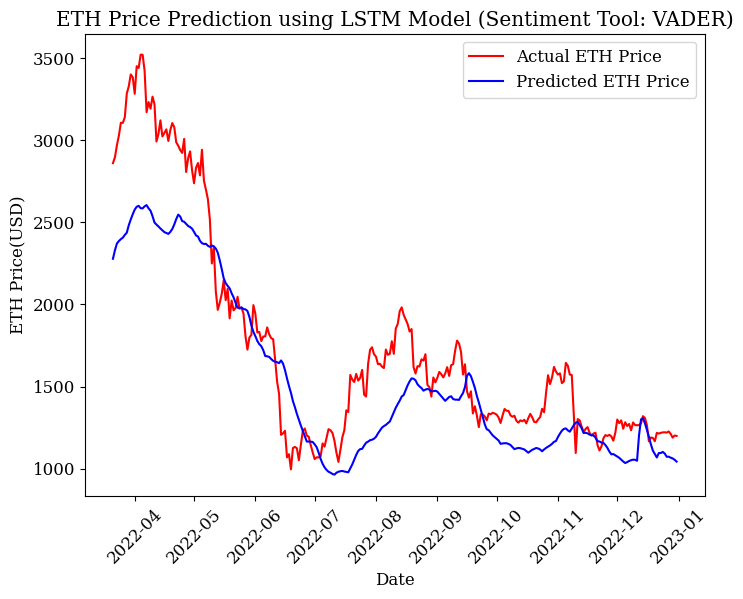

In [66]:
plt.figure(figsize=(8, 6))
plt.plot(df_for_testing['price'].iloc[30:], color = 'red', label = 'Actual ETH Price')
plt.plot(n_df['price'], color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction using LSTM Model (Sentiment Tool: VADER)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('ETH Price(USD)')
plt.legend()
plt.show()

In [67]:
res = forecast_accuracy(n_df['price'], df_for_testing['price'].iloc[30:],['VADER'])
res

,MAE,MAPE,MSE,RMSE
VADER,262.860063,14.235256,114975.655713,339.080604


In [68]:
my_model_all.save("ETH_ModelC.keras")